# Construction and Characterization of Minimal Erythropoieitic Model + Parameter Testing

# Toy model simulations for IL17/Epo synergy

## Background and definitions:


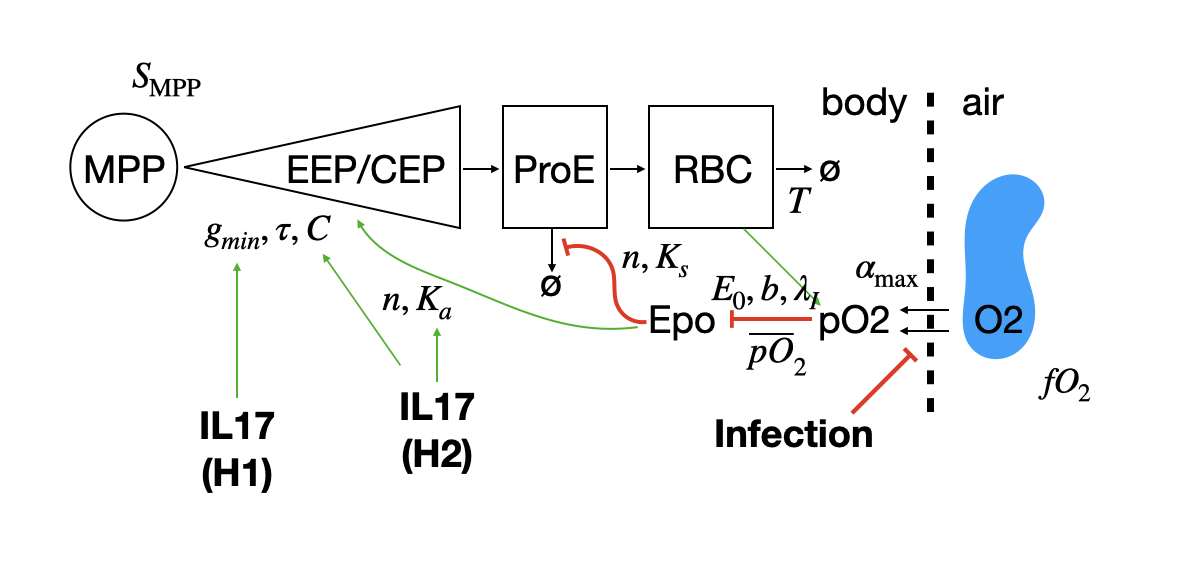

In [1]:
from IPython.display import Image
#### Model schema:
Image(filename="imgs/model_schematic.png", width=600)

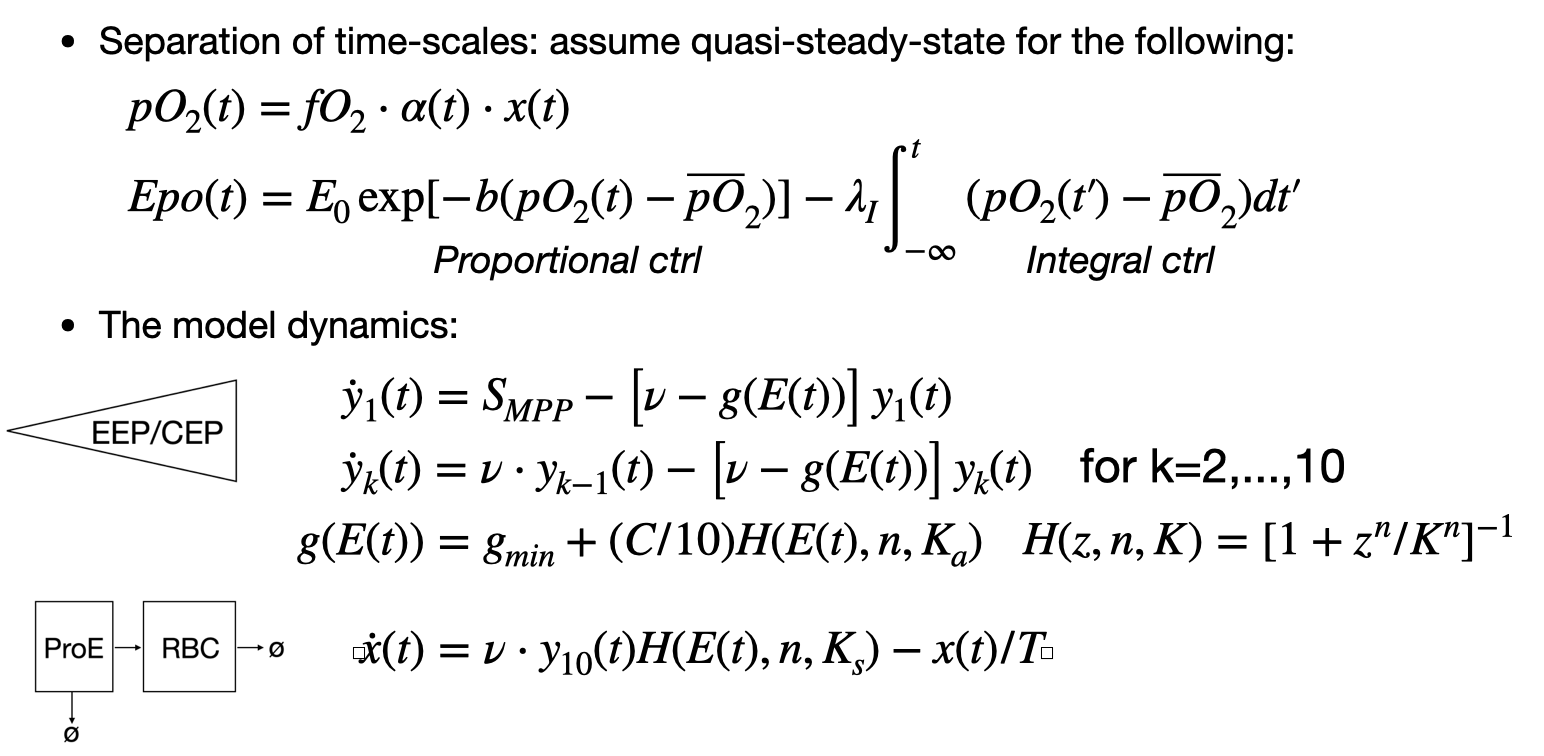

In [2]:
### Model Equations
Image(filename="imgs/model_eqns.png", width=600) 

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from typing import Optional, Callable, Dict, Any, Tuple
import types


from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, minimize

from dataclasses import dataclass, field

import matplotlib.style as style
style.core.USER_LIBRARY_PATHS.append("/Users/qiuwu/.matplotlib/stylelib")

qw_light = "./qw_light_paper.mplstyle"
plt.style.use(qw_light)

import warnings
warnings.filterwarnings("ignore")

/Users/qiuwu/miniconda3/envs/py3.10/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Implementation of Model 

In [4]:
def get_gmin(A, N, tau):
    gmin = (1-A**(-1/N))*(N/tau)
    return gmin

In [5]:
@dataclass
class Simulation:
    N: float = 20 # Number of transit amplifying compartments
    
    epo_normalization: str = 'K1' # Set to either 'K1' or to 'E_0' to decide which will be fit while setting the other to 1.0
                                  # For scanning baseline designs, use 'E_0' (to keep baseline at E=1)
                                  # For physiological tuning, use 'K1' (because otherwise tuning will change K1)
    
    T: float = 40  # Lifetime of RBCs (days)
    tau: float = 7 # Mean time to propagate through progenitor pool

    K_r21: float = 2.0 #1.0 #3  # Ratio of K2/K1. Note that K2 is higher, because early compartment less sensitive

    gmin: float = 0.65 #0.8 #0.35 #0.7 #get_gmin(1000, 20, 7) # Baseline progenitor proliferaion at st-state
    del_g: float = 0.65 #1.1 #0.7 #0.5  #(gmax-gmin)
    #gmax: float = 2
    S_mpp = 1/8000
        
    # One of these two parameters is ignored and then fit in units of the other, (see 'epo_normalization')
    E_0: float = 1.0 ### Preset to 1 
    K1: float = 1.0    # Ks - Epo concentration to achieve 50% survival of final RBC progenitors
    
    n_s: int = 2
    n_a: int = 2 # hill coefficient of Epo response
   
    # pSurv: float = 0.2 # Expected Epo-dependent survival rate of progenitors in steady-state
    # baselineAmp: float = 100 # Expected baseline amplification of progenitors

    
    # Trivial parameters:
    pO2_tgt: float = 1.0  # Target pO2
    fO2: float = 1.0      # External available O2
    xBar: float = 1.0 # Cell count at steady state (defined as 1.0)

    
    # Inflammation dynamics:
    alpha_max: float = 1.0 # Baseline absorbance (per unit x), pO2=fO2*x*alpha
    alpha_min: float = 1.0 # Minimum absorbance (lung infection) (per unit x) - when set to max, no disease
    alpha_T: float = 0.001  # Time (days) to reach minimum absorbance
    custom_alpha: Optional[Callable] = None  # Optional custom alpha function
                                            # alpha(self,t), to replace the default function
      
    # Feedback controller
    b: float = 5  # Sensitivity of Epo to pO2 deviation from target (dlog(Epo)/d(pO2))
    L_I: float = 0.05 # Strength of integral control
    integral_term: float = field(init=False, default=0.0)
    _last_t: float = 0.0

 
    # INITIALIZATION SUBROUTINES
    # ==========================
    def __init__(self):
            
        self.alpha_max = self.pO2_tgt / (self.fO2 * self.xBar)  # effective absorbance per RBC
        self.nu = self.N / self.tau  # 1/Lifetime in each transitional state (days)
        
    def __post_init__(self):
        self.alpha_max = self.pO2_tgt / (self.fO2 * self.xBar)  # effective absorbance per RBC
        self.nu = self.N / self.tau  # 1/Lifetime in each transitional state (days)
        
        # Replace alpha function with custom input if provided:
        if self.custom_alpha is not None:
            self.alpha = types.MethodType(self.custom_alpha, self)
        else:
            self.alpha = self.default_alpha

    # THE MODEL EQUATIONS
    # ==========================        
    def H(self, z, K, n):
        return np.abs(z) ** n / (np.abs(z) ** n + K ** n)

        
    def g(self, E_t, K2):
        #return self.gmin + (self.gmax - self.gmin) * self.H(E_t, K2, self.n_a)
        return self.gmin + self.del_g * self.H(E_t, K2, self.n_a)
    

    def S(self, E_t, K1, y10):
        return self.nu * self.H(E_t, K1, self.n_s) * y10


    def default_alpha(self, t):
        return self.alpha_min + (self.alpha_max - self.alpha_min) * np.exp(-t / self.alpha_T)

    def pO2(self, x, alpha_t):
        return self.fO2 * x * alpha_t

    def E(self, t, x):            
        pO2_diff = self.pO2(x, self.alpha(t)) - self.pO2_tgt
        if t == 0:
            self.integral_term = 0  # Reset integral term at t=0
        else:
            self.integral_term += pO2_diff * (t - getattr(self, '_last_t', 0))  # Accumulate the integral term
        self._last_t = t  # Update the last time point
        return self.E_0 * np.exp(-self.b * pO2_diff) - self.L_I * self.integral_term

    # The following are the dynamical equations themselves:
    def model(self, t, variables):
        x, *y = variables

        E_t = self.E(t, x)
        g_t = self.g(E_t, self.K2)

        dxdt = self.S(E_t, self.K1, y[-1]) - x / self.T

        dydt = [0] * self.N  # Initialize list of progenitor states
        dydt[0] = self.S_mpp - (self.nu - g_t) * y[0]  # First progenitor
        for i in range(1, self.N):
            dydt[i] = self.nu * y[i - 1] - (self.nu - g_t) * y[i]  # Subsequent progenitors

        return [dxdt] + dydt  # Convert into a list and return

    
    
    # SUBROUTINES TO FIT E0 OR K1 UNITS FROM STEADY-STATE REQUIREMENTS
    # ================================================================
    
    # IF FITTING E_0 WITH UNITS OF K1:
    def steady_state_equations_E0(self, E_0):
        g0 = self.g(E_0,self.K2)
        
        log_y = [np.log(self.S_mpp / (self.nu - g0))]
        for i in range(1, self.N):
            log_y.append( log_y[i - 1] + np.log(self.nu / (self.nu - g0)) )
        xBar = self.S(E_0, self.K1, np.exp(log_y[-1])) * self.T
        return (xBar - self.xBar)**2

    
    def calculate_E0(self):
        initial_guess = 1.0
        #E0_solution = fsolve(self.steady_state_equations, initial_guess,)[0]
        E0_solution = minimize(self.steady_state_equations_E0, 
                               x0=[initial_guess], bounds=[(1e-3, 20)], 
                               tol=1e-30, options={'maxiter': 1000}).x[0]
        return E0_solution

    
    # IF FITTING K1 WITH UNITS OF E_0:
    def steady_state_equations_K1(self, K1):
        K2 = self.K_r21 * K1
        g0 = self.g(self.E_0, K2)

        log_y = [np.log(self.S_mpp / (self.nu - g0))]
        for i in range(1, self.N):
            log_y.append( log_y[i - 1] + np.log(self.nu / (self.nu - g0)) )
        xBar = self.S(self.E_0, K1, np.exp(log_y[-1])) * self.T
        return (self.xBar - xBar)**2


    def calculate_K1(self):        
        initial_guess = 1.0
        K1_solution = minimize(self.steady_state_equations_K1, x0=[initial_guess], bounds=[(1e-3, 20)]).x[0]
        return K1_solution

    # THE SUBROUTINE THAT SETS THE MISSING PARAMTER (K1 OR E0) AND GETS STEADY-STATE:
    def initialize_steady_state(self):
        if self.epo_normalization == 'K1':
            self.K1 = self.calculate_K1()
            #print(f'{self.K1}')
            self.K2 = self.K_r21 * self.K1
        elif self.epo_normalization == 'E_0':
            self.K2 = self.K_r21 * self.K1
            self.E_0 = self.calculate_E0()
        else:
            raise ValueError("epo_normalization must be 'E_0' or 'K1' only.")
            
        
        g0 = self.g(self.E_0,self.K2)

        self.y_ss = [self.S_mpp / (self.nu - g0)]
        for i in range(1, self.N):
            self.y_ss.append(self.y_ss[i - 1] * self.nu / (self.nu - g0))
        
        # print(f"Steady state values: E_0 = {self.E_0}, xBar = {self.xBar}, y_ss = {self.y_ss}")
        return self.xBar, self.y_ss

    def solve_steady_state(self):
        g0 = self.g(self.E_0,self.K2)
  
        self.y_ss = [self.S_mpp / (self.nu - g0)]
        for i in range(1, self.N):
            self.y_ss.append(self.y_ss[i - 1] * self.nu / (self.nu - g0))
        
        return self.xBar, self.y_ss


    # POST-RUN DATA ANALYSIS SUBROUTINES
    # ==================================
    def find_time_for_midpoint(self, t, x):
        midpoint_value = 0.5 * (np.max(x) + np.min(x))

        for i in range(len(x) - 1, 0, -1):
            if (x[i] - midpoint_value) * (x[i - 1] - midpoint_value) <= 0:  # Crossing midpoint_value
                return t[i]
        return None  # Return None if no crossing is found

    def find_time_for_O2(self, t, x):
        target_value = 0.95
        
        for i in range(1, len(x)):
            if x[i - 1] < target_value <= x[i]:  # Crosses from below to above
                if x[i] == target_value:
                    return t[i]
                elif x[i - 1] == target_value:
                    return t[i - 1]
                else:
                    return t[i]
        return None  # Return None if no crossing is found  

    
    # THE SUBROUTINE THAT RUNS THE SIMULATION AND GENERATES POST-RUN ANALYSES
    # =======================================================================    
    def simulate(self, t_span, t_eval, perturbations: Optional[Dict[str, float]] = None):
        
        # Apply perturbations if provided
        if len(perturbations)>0:
            for key, value in perturbations.items():
                if hasattr(self, key):
                    setattr(self, key, value)
        
        self.__init__()

        # Initialize steady state
        self.xBar, self.y_ss = self.initialize_steady_state()
        #print('K1:',self.K1)
        
         # Ensure the model function uses the updated parameters
        initial_conditions = [self.xBar] + self.y_ss
        
        self.__post_init__()
        
        
        sol = solve_ivp(self.model, t_span, initial_conditions, t_eval=t_eval,  method='BDF')
        
        self._last_t = 0.0  # Reset integral term time tracking

        sol_x = sol.y[0]
        E_t = [self.E(t, x) for t, x in zip(sol.t, sol_x)]
        alpha_t = [self.alpha(t) for t in sol.t]
        pO2_t = [self.pO2(x, alpha) for x, alpha in zip(sol_x, alpha_t)]
        surv_t = [self.H(E, self.K1, self.n_s) for E in E_t]
        flux_t = [self.nu * y10 for y10 in sol.y[-1, :]]
        t_mid = self.find_time_for_midpoint(sol.t, pO2_t)
        t_O2 = self.find_time_for_O2(sol.t, pO2_t)

        self.results = {
            't': sol.t, 
            'x': sol_x, 
            'y': sol.y[1:], 
            'E': E_t, 
            'alpha': alpha_t, 
            'pO2': pO2_t, 
            'surv': surv_t, 
            'flux': flux_t, 
            't_midO2': t_mid, 
            't_O2_rec': t_O2
        }
        
        return self.results



# Model Simulation Functions

In [6]:
# Function to run simulations for multiple parameter sets
def run_simulations(parameter_sets, t_span, t_eval):
    output_dynamics = {}
    for key, param_deviation in parameter_sets.items():
        simulation = Simulation()
        results = simulation.simulate(t_span, t_eval,param_deviation)
        output_dynamics[key] = results
        # print(f"E(0) in {key}: {results['E'][0]}")
    return output_dynamics

# This subroutine models loss of lung capacity - first gradual, then accelerating
def biphasic_alpha(instance, t):
    # A smooth function simulating loss of lung capacity over time
    # Can try different functional forms...
    return instance.alpha_min + (instance.alpha_max-instance.alpha_min)*np.exp(- (t/(4*instance.alpha_T))- 2*(t/(2*instance.alpha_T))**2)

# Function for mixture distribution for sampling parameters
def log_or_linear_random(min_value, max_value,p,loc, scale):
    lin = np.random.uniform(min_value,max_value)
    mid = np.abs(np.random.normal(loc=loc,scale=scale))
    log = np.exp(np.random.uniform(np.log(min_value+1e-2), np.log(max_value)))
    output = np.random.choice([lin,mid, log], p=p)
    return np.abs(output)

def pO2_performance_metric(output_dynamics,penalty=2,target=1):
    po2_t = np.array(output_dynamics['pO2'])
    t = np.array(output_dynamics['t'])
    performance_across_time = target - po2_t[:-1]
    dt = t[1:]-t[0:-1]
    #performance_across_time[performance_across_time < 0 ] = 0
    return np.sum(abs(performance_across_time)**(penalty) * t[:-1] * dt )**0.5

def pO2_ITSE(output_dynamics,target=1):
    po2_t = np.array(output_dynamics['pO2'])
    t = np.array(output_dynamics['t'])
    performance_across_time = target - po2_t[:-1]
    dt = t[1:]-t[0:-1]
    #performance_across_time[performance_across_time < 0 ] = 0
    return np.sum(performance_across_time**2 * t[:-1] * dt )**0.5

def pO2_ISE(output_dynamics,target=1):
    po2_t = np.array(output_dynamics['pO2'])
    t = np.array(output_dynamics['t'])
    performance_across_time = target - po2_t[:-1]
    dt = t[1:]-t[0:-1]
    #performance_across_time[performance_across_time < 0 ] = 0
    return np.sum(performance_across_time**2 * dt )


## Function for plotting output dynamics of simulations
def plot_variable_H2(output_dynamics,class_list):
    vars = ['pO2','x','y','surv','E']
    plt.figure(figsize=(10,2))
    for i,var in enumerate(vars):
        plt.subplot(1,5,i+1)
        for i,sim in enumerate(class_list):
            out = output_dynamics[sim]
            if i>=2:
                style = '--'
            else:
                style='-'
                
            if var == 'y':
                plt.plot(out['t'],out[var][-1],label=sim,linestyle=style,)
                #plt.yscale('log',base=10)
                #plt.ylim([0.0005,0.01])
            else:
                plt.plot(out['t'],out[var],label=sim,linestyle=style,)
                if var=='surv':
                    plt.ylim([0,1])
        plt.xlabel('Time (days)')
        plt.ylabel(var)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1,1),fontsize=8)
    sns.despine()

## Function for plotting sensitivity simulations
def check_plots(tracker_df):
    normoxia = tracker_df[tracker_df.label=='param_testing_normoxia']
    hypoxia = tracker_df[tracker_df.label=='param_testing_hypoxia']
    plt.figure(figsize=(6,2))
    plt.subplot(1,3,1)
    sns.scatterplot(x=1/np.array(hypoxia.t_O2_rec),
                    y=1/(np.array(normoxia.progenitor_surv)+1e-2),
                    hue = np.array(normoxia.param_val),
                    palette='Reds',edgecolor='k',
              
            );
    
    plt.ylabel('Resting Cost\n(1/Freq. Prog. Surv.)')
    plt.xlabel('Speed:\n1/(Time to Target pO2 (Days))')
    plt.title(f'Tradeoff for adjusting {poi}', pad = 10,fontsize=8)
    plt.xlim([-0.01,0.15])
    plt.yscale('log')
    plt.legend([],[],frameon=False)
    sns.despine()
    
    plt.subplot(1,3,2)
    tracker_df = hypoxia.dropna()
    plt.plot(tracker_df.param_val,
             tracker_df.t_O2_rec,
             marker='o',markersize=5,
    
            );
    plt.xlabel(poi)
    plt.ylim([0,120])
    plt.ylabel('Time to Target pO2 (Days)')
    plt.title(f'Effect of {poi} on Recovery',pad=10,fontsize=8)
    sns.despine()
    
    plt.subplot(1,3,3)
    plt.plot(obtain_sensitivity_to_param(tracker_df,poi)[0],
             obtain_sensitivity_to_param(tracker_df,poi)[1],
             marker='o',
             markersize=5,
    
            );
    plt.xlabel(poi)
    plt.ylabel(f'dlog(t_pO2)/dlog({poi})')
    plt.title(f'Sensitivity',pad = 10,fontsize=8)
    sns.despine()
    plt.tight_layout()
    #plt.savefig(f'figures/{poi}_adjusted_values_of_interest.pdf')



In [109]:
# Simulation with Default Parameters and Hypoxia Onset
parameter_sets = {
# Baseline Model
'baseline_hypoxia':{
    'epo_normalization': 'E_0',
    'gmin': 0.8,
     'K_r21': 1.5,
     'del_g': 1.0,
    'n_a': 1.0,
    'tau':10,
    'alpha_min': 0.7, 'alpha_T': 5, 'custom_alpha':biphasic_alpha},

'baseline_normoxia':{
    'epo_normalization': 'E_0',
    'gmin': 0.8,
    'K_r21': 1.5,
    'del_g': 1.0,
    'n_a': 1.0,
    'tau':10,
},

'tuned_hypoxia':{
    'del_g': 0.83,
    'K_r21': 2.62,
    'gmin' : 0.83,
    'n_a' : 1.0,
    'alpha_min': 0.7, 'alpha_T': 5, 'custom_alpha':biphasic_alpha},

'tuned_normoxia':{
    'del_g': 0.83,
    'K_r21': 2.62,
    'gmin' : 0.83,
    'n_a' : 1.0,
}

}
 

t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

output_dynamics = run_simulations(parameter_sets, t_span, t_eval)

pSurv baseline: 0.0037554741800932944
pSurv tuned:    0.08663644995681785

rate baseline: 1.4332955148710094
rate tuned   : 0.9213380616143976


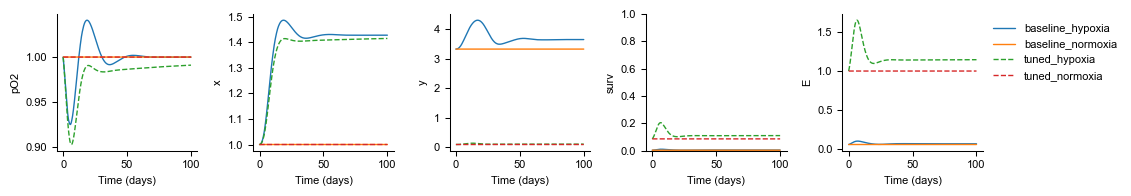

In [110]:
plot_variable_H2(output_dynamics,['baseline_hypoxia','baseline_normoxia',
                                  'tuned_hypoxia', 'tuned_normoxia'
])
print('pSurv baseline:',output_dynamics['baseline_normoxia']['surv'][0])
print('pSurv tuned:   ',output_dynamics['tuned_normoxia']['surv'][0])
print('')
print('rate baseline:', 1/pO2_performance_metric(output_dynamics['baseline_hypoxia']))
print('rate tuned   :',1/pO2_performance_metric(output_dynamics['tuned_hypoxia']))

# Model Parameter Scanning Across Range : Sensitivity of Tradeoffs (Baseline Survival of Progenitors and Speed of Response)
To understand the contribution of the range of each parameter, we performed parameter scanning where we change one parameter at a time in the bases model to do determine whether and how each parameter contributes to navigating trade off space.

We solve for the model at baseline (unperturbed) $pO_2$ with one parameter adjusted. We also solve for the same model, but with an imposition of drop in $pO_2%$ due to ineffective absorbance via adjusting $\alpha(t)$

In [389]:
baseline_params = {
    'tau'  : 7, 
    'del_g': 0.9,
    'K_r21' : 2,
    'n_a':   2,
    'n_s':   2,
    'S_mpp': 1/8000,
    'gmin': 0.3,
}
tau_min = 5
tau_max = 10
param_range_dict ={
'tau'  : [tau_min,tau_max], ## Mean time to propagate progenitor pool
'gmin': [0,3], ## The extent of Epo independent amplification
}

param_scan_type = {
'tau'  : 'lin',
'gmin': 'lin',
}

param_num_steps = {
'tau'  : (tau_max-tau_min)+1,
'gmin': 51
}

params = ['gmin', 'tau', 
         ]

In [390]:
def is_normoxia_stable(x_values, tolerance=1e-3):
    return np.abs(x_values[-1] - x_values[0]) < tolerance


In [391]:
import warnings
warnings.filterwarnings("ignore")
# Each parameter set corresponds to a different condition. 
# The simulations assume a new steady-state is reached before hypoxia onset

tracker_df = pd.DataFrame(columns = ['gmin','tau','K_r21',
           'progenitor_flux', 'progenitor_surv', 'peak_flux', 'min_pO2',
           'mid_pO2_t', 't_O2_rec','penalty_pO2_t'])

all_param_df = tracker_df.copy()

t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

use_alpha_T = 5

param_set = {'normoxia_params':baseline_params,
             'hypoxia_params':{**baseline_params,**{'alpha_min': 0.7, 'alpha_T': use_alpha_T, 'custom_alpha':biphasic_alpha}}}
baseline_comparison = run_simulations(param_set, t_span, t_eval)
baseline_pO2_performance = 1/pO2_performance_metric(baseline_comparison['hypoxia_params'])
baseline_cost = 1/baseline_comparison['normoxia_params']['surv'][0]
for k_r21 in [2,1e3]:
    for dif_tau in np.linspace(param_range_dict['tau'][0], param_range_dict['tau'][1], param_num_steps['tau']):
        for gmin_val in np.linspace(param_range_dict['gmin'][0], param_range_dict['gmin'][1], param_num_steps['gmin']):
            
            # Initialize the parameter sets for each condition
            parameter_sets = {
                'param_testing_hypoxia': {**baseline_params, 'alpha_min': 0.7, 'alpha_T': use_alpha_T, 'custom_alpha': biphasic_alpha},
                'param_testing_normoxia': {**baseline_params}
            }
            
            # Update parameters
            parameter_sets['param_testing_hypoxia']['tau'] = dif_tau
            parameter_sets['param_testing_hypoxia']['gmin'] = gmin_val
            parameter_sets['param_testing_hypoxia']['K_r21'] = k_r21
            parameter_sets['param_testing_normoxia']['tau'] = dif_tau
            parameter_sets['param_testing_normoxia']['gmin'] = gmin_val
            parameter_sets['param_testing_normoxia']['K_r21'] = k_r21
            
            try:
                # Run simulations
                output_dynamics = run_simulations(parameter_sets, t_span, t_eval)
                
                # Check stability in normoxia
                if is_normoxia_stable(output_dynamics['param_testing_normoxia']['x']):
                    # Create a temporary DataFrame for this parameter combination
                    hypoxia_df = pd.DataFrame(columns=['gmin', 'tau','K_r21', 'progenitor_flux', 'progenitor_surv', 
                                                       'peak_flux', 'min_pO2', 'mid_pO2_t', 't_O2_rec', 
                                                       'penalty_pO2_t', 'resting_cost'])
                    
                    k = 'param_testing_hypoxia'
                    
                    # Fill the temporary DataFrame with results
                    hypoxia_df.loc[0, 'progenitor_flux'] = output_dynamics[k]['flux'][-1]
                    hypoxia_df.loc[0, 'progenitor_surv'] = output_dynamics['param_testing_normoxia']['surv'][0]
                    hypoxia_df.loc[0, 'peak_flux'] = np.max(output_dynamics[k]['flux'])
                    hypoxia_df.loc[0, 'min_pO2'] = np.min(output_dynamics[k]['pO2'])
                    hypoxia_df.loc[0, 'penalty_pO2_t'] = pO2_performance_metric(output_dynamics[k])
                    hypoxia_df.loc[0, 'mid_pO2_t'] = output_dynamics[k]['t_midO2']
                    hypoxia_df.loc[0, 't_O2_rec'] = output_dynamics[k]['t_O2_rec']
                    hypoxia_df.loc[0, 'tau'] = dif_tau
                    hypoxia_df.loc[0, 'gmin'] = gmin_val
                    hypoxia_df.loc[0, 'K_r21'] = k_r21
                    hypoxia_df.loc[0, 'resting_cost'] = 1/output_dynamics['param_testing_normoxia']['surv'][0]
                    
                    # Append to tracker_df
                    tracker_df = pd.concat([tracker_df, hypoxia_df], ignore_index=True)
                    
            except Exception as e:
                continue

# After completing all parameter iterations, append tracker_df to all_param_df once
all_param_df = pd.concat([all_param_df, tracker_df], ignore_index=True)

### Combining all parameter plots together to look at effects in trade off space

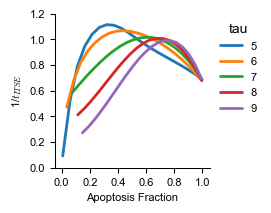

In [392]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
val = 'gmin'
plt.figure(figsize=(2,2))
# Setting K_r21 == 2 as baseline
for i in range(1,tau_max):
    tau_5 = all_param_df[(all_param_df.tau==i) & (all_param_df.K_r21==2)]
    if tau_5.shape[0] == 0:
        continue
    x = 1 - np.array(tau_5.progenitor_surv)
    y = np.array(1 / np.array(tau_5.penalty_pO2_t))[np.argsort(x)]
    x = np.sort(x)

    
    # Fit a Univariate Spline with a specified smoothing factor (e.g., s=0.5)
    spline = UnivariateSpline(x, y, s=1e-2)
    
    # Generate smooth x values for plotting the spline fit
    x_smooth = np.linspace(min(x), max(x), 20)
    y_smooth = spline(x_smooth)
    
    # plt.figure(figsize= (1.8,1.8))
    # Plotting the original data and spline fit

    if i> 10:
        x = ':'
    else:
        x='-'
    plt.plot(x_smooth, y_smooth,  label=i,  linewidth=2,linestyle=x)
    #plt.scatter(x, y, s=10,)
    plt.xlabel('Apoptosis Fraction')
    plt.ylabel(r'1/$t_{ITSE}$')
    plt.xlim([-0.05,1.05])
    plt.ylim([0, 1.2])
    plt.xticks(np.arange(0,1.2,0.2))
    sns.despine()
plt.legend(bbox_to_anchor=(1,1),title='tau')
#plt.savefig('figures/apoptosis_v_tISE_navigating_gmin_with_preset_vals_AMP_1000.pdf',dpi=100)
plt.show()


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


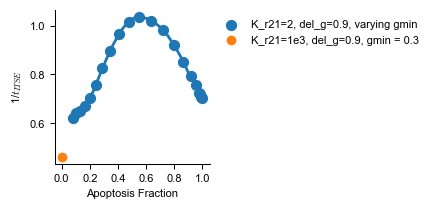

In [395]:
days = 7
tau_7 = all_param_df[(all_param_df.tau==days) & (all_param_df.K_r21==2)]
tau_2_k_r21_low = all_param_df[(all_param_df.tau==days) & (all_param_df.K_r21==1e3)]
   
x = 1 - np.array(tau_7.progenitor_surv)
y = np.array(1 / np.array(tau_7.penalty_pO2_t))[np.argsort(x)]
x = np.sort(x)


# Fit a Univariate Spline with a specified smoothing factor (e.g., s=0.5)
spline = UnivariateSpline(x, y, s=1e-5)

# Generate smooth x values for plotting the spline fit
x_smooth = np.linspace(min(x), max(x), 20)
y_smooth = spline(x_smooth)

plt.figure(figsize=(2,2))
plt.plot(x_smooth, y_smooth,  linewidth=2,linestyle='-')
plt.scatter(x, y, s=50,label='K_r21=2, del_g=0.9, varying gmin')

plt.scatter(1-tau_2_k_r21_low[tau_2_k_r21_low.gmin==0.3].progenitor_surv,
            1/tau_2_k_r21_low[tau_2_k_r21_low.gmin==0.3].penalty_pO2_t, label='K_r21=1e3, del_g=0.9, gmin = 0.3')
plt.xlabel('Apoptosis Fraction')
plt.ylabel(r'1/$t_{ITSE}$')
plt.xlim([-0.05,1.05])
#plt.ylim([0, 1.5])
plt.xticks(np.arange(0,1.2,0.2))
sns.despine()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('figures/apoptosis_v_ITSE_navigating_gmin_tau_7.pdf',dpi=100)
plt.show()


In [367]:
# all_param_df.to_csv('varying_tau_gmin_k_r21.csv')

In [381]:
# tau_2_k_r21_low

,gmin,tau,K_r21,progenitor_flux,progenitor_surv,peak_flux,min_pO2,mid_pO2_t,t_O2_rec,penalty_pO2_t,resting_cost
